### Imports and constants

In [1]:
import math
import numpy as np
import pandas as pd
import shapely
import matplotlib
from matplotlib import pylab as plt
import geopandas as gpd
import pyproj
import contextily as ctx
from time import perf_counter

from shapely.geometry import Point, LineString, MultiPoint, Polygon, GeometryCollection
from shapely.ops import unary_union, nearest_points
from shapely.wkt import loads as wkt_load

crs_gps = pyproj.CRS.from_epsg('4326') # WGS84 Merkator (degrees)
crs_web = pyproj.CRS.from_epsg('3857') # Pseudo-Merkator (meters)
crs_est = pyproj.CRS.from_epsg('3301') # Estonian Coordinate System

In [2]:
data = pd.read_csv("data/driveways_cleaned.csv", index_col="global_id")
data["geometry"] = data["geometry"].apply(wkt_load)
gdf_data = gpd.GeoDataFrame(data, geometry="geometry", crs=crs_est)
# Remove 3 instances of MultiLineStrings (they don't allow for coords)
gdf_data = gdf_data[gdf_data.geometry.geom_type == "LineString"]
gdf_data.head()

,directionality,length,speed_limit,geometry
global_id,,,,
{8F969862-9F81-480E-AB2F-89DF27005924},0.0,30.009882,50.0,"LINESTRING (659566.000 6469788.800, 659568.900..."
{BE820666-6211-42A5-9E93-5C17A9F1D2AC},0.0,11.882761,50.0,"LINESTRING (659564.600 6469800.600, 659566.000..."
{ECAC42D9-5D54-4639-8BC9-63481F9B373A},0.0,48.868986,50.0,"LINESTRING (659564.600 6469800.600, 659583.400..."
{BF989B70-DEF6-4B25-BCC6-80F2C0223549},0.0,35.750524,50.0,"LINESTRING (659562.700 6469836.300, 659564.600..."
{9BB99A5D-705B-40DD-A2A4-44588D20AA9E},0.0,27.115494,50.0,"LINESTRING (659562.700 6469836.300, 659589.700..."


### Prepare data structures of nodes and edges

**Add start and end points of roads to data**

In [3]:
gdf_data["start_node_x"] = gdf_data.geometry.apply(lambda row: round(row.coords[0][0],3))
gdf_data["start_node_y"] = gdf_data.geometry.apply(lambda row: round(row.coords[0][1],3))
gdf_data["end_node_x"] = gdf_data.geometry.apply(lambda row: round(row.coords[-1][0],3))
gdf_data["end_node_y"] = gdf_data.geometry.apply(lambda row: round(row.coords[-1][1],3))
gdf_data.head()

,directionality,length,speed_limit,geometry,start_node_x,start_node_y,end_node_x,end_node_y
global_id,,,,,,,,
{8F969862-9F81-480E-AB2F-89DF27005924},0.0,30.009882,50.0,"LINESTRING (659566.000 6469788.800, 659568.900...",659566.0,6469788.8,659569.2,6469759.0
{BE820666-6211-42A5-9E93-5C17A9F1D2AC},0.0,11.882761,50.0,"LINESTRING (659564.600 6469800.600, 659566.000...",659564.6,6469800.6,659566.0,6469788.8
{ECAC42D9-5D54-4639-8BC9-63481F9B373A},0.0,48.868986,50.0,"LINESTRING (659564.600 6469800.600, 659583.400...",659564.6,6469800.6,659613.4,6469802.9
{BF989B70-DEF6-4B25-BCC6-80F2C0223549},0.0,35.750524,50.0,"LINESTRING (659562.700 6469836.300, 659564.600...",659562.7,6469836.3,659564.6,6469800.6
{9BB99A5D-705B-40DD-A2A4-44588D20AA9E},0.0,27.115494,50.0,"LINESTRING (659562.700 6469836.300, 659589.700...",659562.7,6469836.3,659589.7,6469838.8


**Prepare node and edge lists.**

In [4]:
start_lists = perf_counter()

In [5]:
# nodes are start and end points of all roads
nodes = []
# edges have a start point, an end point and a length
edges = []
# if the road has two-way traffic, two edges should be added
for index, row in gdf_data.iterrows():
    # there were 3 lines that were MultiLineString which didn't allow for coords, so I excluded them
    if row.geometry.geom_type != "LineString":
        continue
    start_node = [row.start_node_x, row.start_node_y]
    end_node = [row.end_node_x, row.end_node_y]
    nodes.append(start_node)
    nodes.append(end_node)
    edges.append([start_node, end_node, row.length])
    # if traffic is two-way, need to add an edge from end to beginning
    if row.directionality == 0:
        edges.append([end_node, start_node, row.length])

In [6]:
# remove duplicate nodes
nodes = np.array(list(set(tuple(node) for node in nodes)))
print(f'Example of a node: {nodes[0]}')
print(f'Example of an edge: {edges[1]}')
print(f'Nr. of nodes: {len(nodes)}; nr. of edges: {len(edges)}')

Example of a node: [ 657756.3 6474954.3]
Example of an edge: [[659569.2, 6469759.0], [659566.0, 6469788.8], 30.009882472586003]
Nr. of nodes: 8989; nr. of edges: 19841


In [7]:
# Probably would be a lot faster if nodes were denoted as indices in edges. Should have done it before.
for i in range(len(nodes)):
    node = nodes[i]
    for j in range(len(edges)):
        start_node, end_node, length = edges[j]
        if type(start_node) is list and node[0] == start_node[0] and node[1] == start_node[1]:
            edges[j][0] = i
        if type(end_node) is list and node[0] == end_node[0] and node[1] == end_node[1]:
            edges[j][1] = i

In [8]:
edges = [tuple(edge) for edge in edges]
print(edges[:5])

[(4611, 7819, 30.009882472586003), (7819, 4611, 30.009882472586003), (244, 4611, 11.88276062201036), (4611, 244, 11.88276062201036), (244, 3986, 48.86898622140877)]


In [9]:
print(f'Time taken to create edges: {perf_counter() - start_lists}')

Time taken to create edges: 74.19032299999999


### Create Shapely objects for Delta and Lõunakeskus (coordinates are from Google Maps)

In [10]:
# https://epsg.io/transform#s_srs=4326&t_srs=3301 - used this to convert from gps to estonian coordinate system
# needed to invert latitude and longitude
delta = Point(659351.9779390106, 6474942.48407838)
lounakeskus = Point(656661.9914198933, 6471868.239886967)
sirius = Point(659234.2258483924, 6471525.160984464)

In [11]:
print(delta.distance(lounakeskus))
print(delta.distance(sirius))

4084.973050274384
3419.351207913362


### Find closest road to input point.

In [12]:
# distance in meters
def get_closest_road(point, road_table):
    distances_to_roads = point.distance(road_table["geometry"])
    return distances_to_roads.idxmin()

delta_road = get_closest_road(delta, gdf_data)
lounakeskus_road = get_closest_road(lounakeskus, gdf_data)
sirius_road = get_closest_road(sirius, gdf_data)

In [13]:
print(delta_road)
print(lounakeskus_road)
print(sirius_road)

{C5032583-0DB6-4E36-B246-840F2E9468E4}
{961D4E45-540C-4C9B-9F04-6C477C050B47}
{0BFFC4B4-2FB6-4811-8EF7-ED280A0345B7}


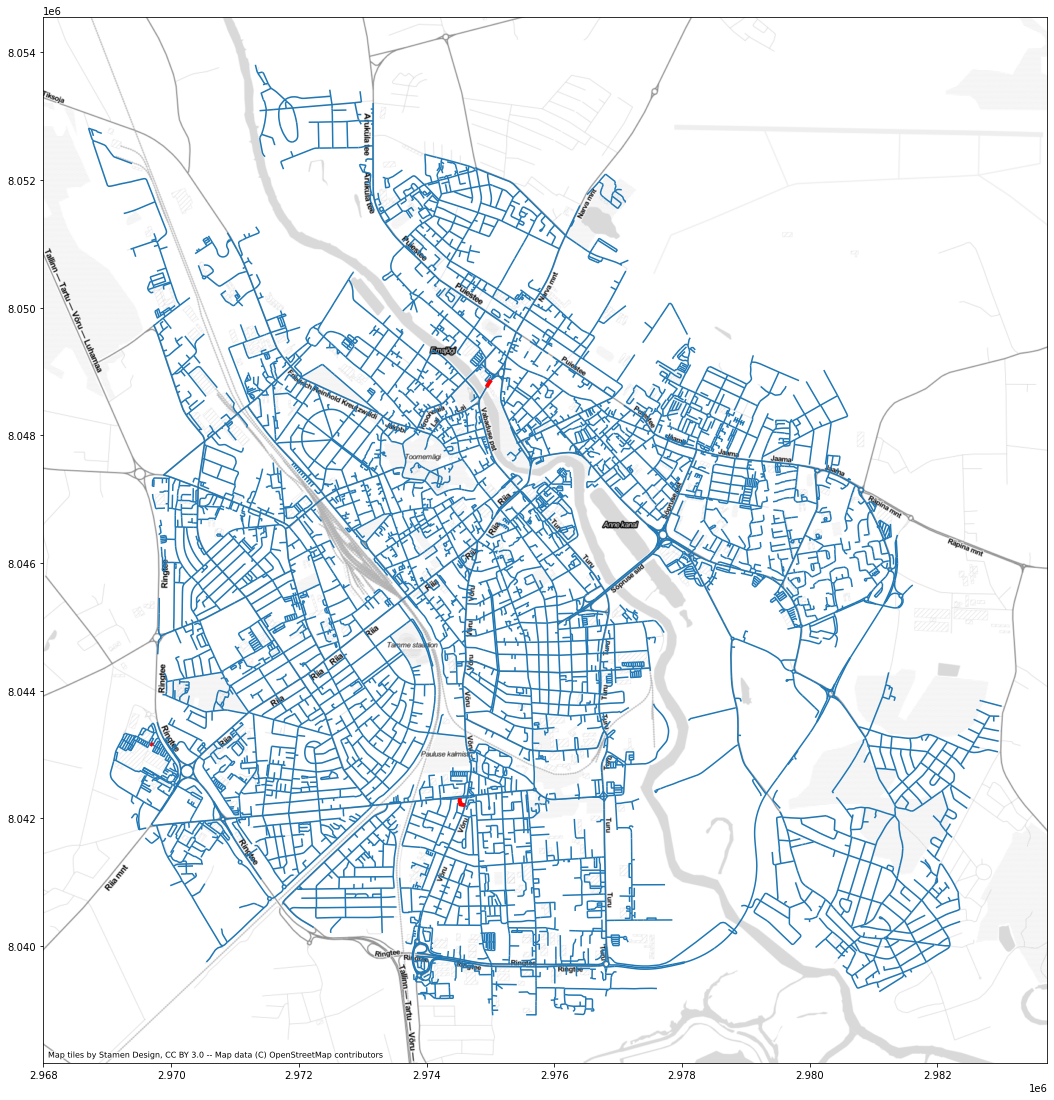

In [14]:
# visualize the closest roads to Delta, Lounakeskus, and Sirius

fig,ax = plt.subplots(1,1, figsize=(18,20))
# Need to change CRS for plotting
gdf_data.to_crs(crs_web).plot(ax=ax)
gdf_data.loc[[delta_road, lounakeskus_road, sirius_road]].to_crs(crs_web).plot(ax=ax, color="red", lw=4)
ctx.add_basemap(ax=ax, source=ctx.providers.Stamen.TonerLite)

### Implement a first version of Dijkstra

**Relied on this video (https://www.youtube.com/watch?v=pVfj6mxhdMw) and my own poor code from the practice session to code Dijkstra from adjacency matrix.**

In [15]:
#create distance matrix

n = len(nodes)
distance_matrix = np.full((n,n), math.inf)
for edge in edges:
    distance_matrix[edge[0], edge[1]] = edge[2]

In [16]:
def dijkstra(distance_matrix, start_point_idx):
    unvisited = np.arange(len(distance_matrix))
    previous_vertices = np.full(len(distance_matrix), None)
    distances_from_start = np.full(len(distance_matrix), math.inf)
    
    for idx in np.argwhere(distance_matrix[start_point_idx] < math.inf):
        previous_vertices[idx[0]] = start_point_idx
        distances_from_start[idx[0]] = distance_matrix[start_point_idx][idx[0]]
        distances_from_start[start_point_idx] = 0
    unvisited = np.delete(unvisited, start_point_idx)
    while len(unvisited > 0):
        #if len(unvisited) % 100 == 0 or len(unvisited) < 100:
        #    print(len(unvisited))
        vertex = None
        for candidate_vertex in np.argsort(distances_from_start):
            if candidate_vertex in unvisited:
                vertex = candidate_vertex
                break
        distances_from_vertex = distance_matrix[vertex]
        neighbors = np.argwhere(distances_from_vertex < math.inf)
        for neighbor in neighbors:
            distance_with_vertex = distances_from_start[vertex] + distances_from_vertex[neighbor[0]]
            distance_without_vertex = distances_from_start[neighbor[0]]
            if distance_with_vertex < distance_without_vertex:
                distances_from_start[neighbor[0]] = distance_with_vertex
                previous_vertices[neighbor[0]] = vertex
        vertex_idx_in_unvisited = np.argwhere(unvisited == vertex)
        unvisited = np.delete(unvisited, vertex_idx_in_unvisited)
    return distances_from_start, previous_vertices

### Seems terribly slow, but moving on.

In [17]:
delta_road

'{C5032583-0DB6-4E36-B246-840F2E9468E4}'

In [18]:
delta_start = (gdf_data.loc[delta_road].start_node_x, gdf_data.loc[delta_road].start_node_y)
lounakeskus_end = (gdf_data.loc[lounakeskus_road].end_node_x, gdf_data.loc[lounakeskus_road].end_node_y)
sirius_end = (gdf_data.loc[sirius_road].end_node_x, gdf_data.loc[sirius_road].end_node_y)

In [19]:
# find their indices in nodes 
print(np.argwhere(delta_start == nodes)) #6313
print(np.argwhere(lounakeskus_end == nodes)) #5362
print(np.argwhere(sirius_end == nodes)) #81

[[ 529    0]
 [ 562    1]
 [4428    0]
 [5821    0]
 [6313    0]
 [6313    1]]
[[ 289    1]
 [5362    0]
 [5362    1]]
[[81  0]
 [81  1]]


In [20]:
print(nodes[6313], nodes[5362], nodes[81])

[ 659308.9 6474915.1] [ 656683.8 6471866. ] [ 659271.3 6471473.1]


In [21]:
#find shortest path from delta_start

start_dijkstra = perf_counter()
d, pv = dijkstra(distance_matrix, 6313)

print(f'Time taken: {perf_counter() - start_dijkstra}')

Time taken: 157.07594475000002


In [22]:
# input is list of previous vertices
def recreate_path(pv, end_idx):
    path = [end_idx]
    prev = pv[end_idx]
    while prev != None:
        path.append(prev)
        prev = pv[prev]
    path.reverse()
    return path

def get_id_by_coords(start_coords, end_coords, df):
    row = df[(df.start_node_x == start_coords[0]) & (df.start_node_y == start_coords[1]) & (df.end_node_x == end_coords[0]) & (df.end_node_y == end_coords[1]) | (df.end_node_x == start_coords[0]) & (df.end_node_y == start_coords[1]) & (df.start_node_x == end_coords[0]) & (df.start_node_y == end_coords[1])]
    return row.index[0]

def path_to_ids(path, nodes, df):
    result = []
    for i in range(len(path)-1):
        start_node_idx = path[i]
        start_coords = nodes[start_node_idx]
        end_node_idx = path[i+1]
        end_coords = nodes[end_node_idx]
        result.append(get_id_by_coords(start_coords, end_coords, df))
    return result

path_idxs_lounakeskus = recreate_path(pv, 5362)
path_ids_lounakeskus = path_to_ids(path_idxs_lounakeskus, nodes, gdf_data)

path_idxs_sirius = recreate_path(pv, 81)
path_ids_sirius = path_to_ids(path_idxs_sirius, nodes, gdf_data)

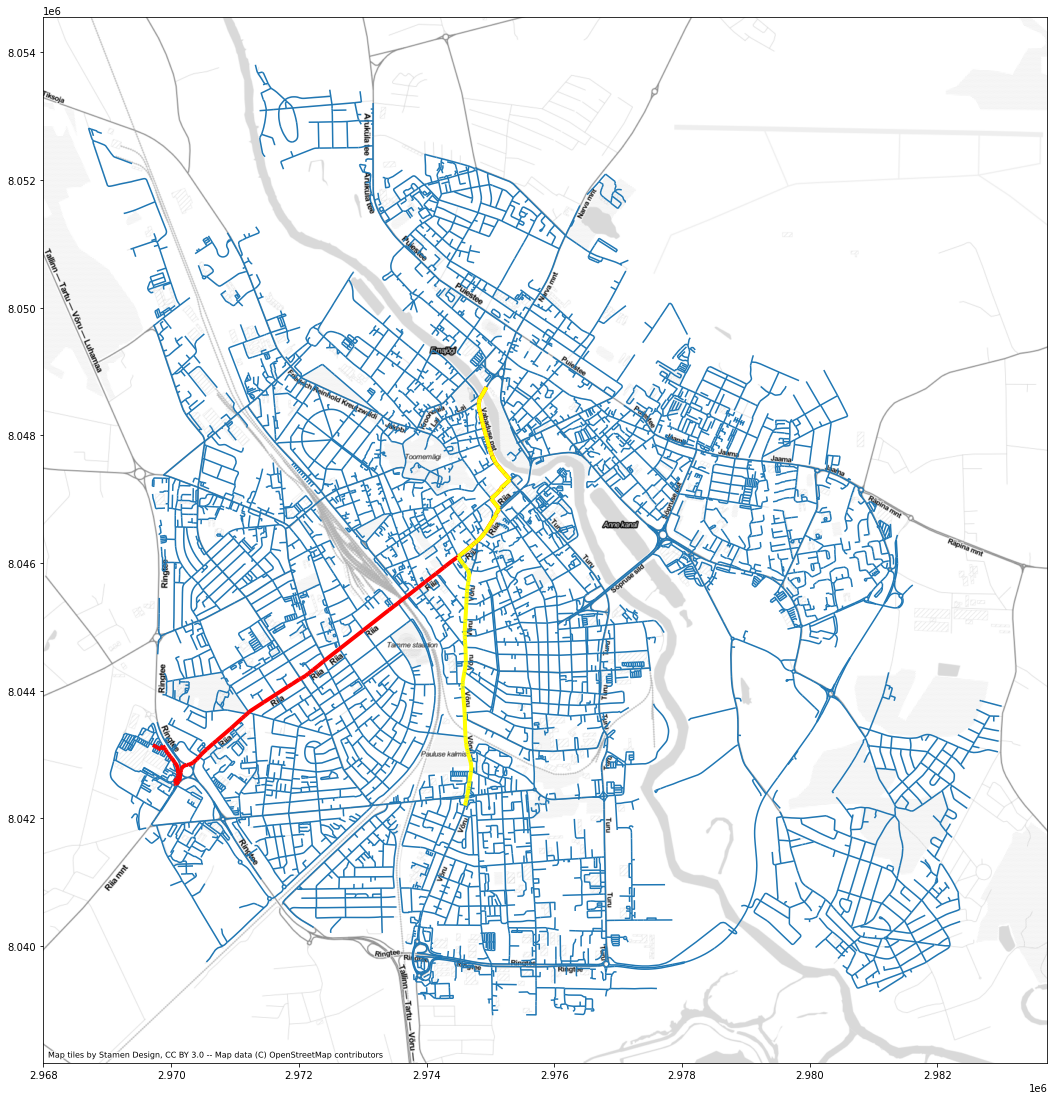

In [23]:
# visualize the path

fig,ax = plt.subplots(1,1, figsize=(18,20))
# Need to change CRS for plotting
gdf_data.to_crs(crs_web).plot(ax=ax)
gdf_data.loc[path_ids_lounakeskus].to_crs(crs_web).plot(ax=ax, color="red", lw=4)
gdf_data.loc[path_ids_sirius].to_crs(crs_web).plot(ax=ax, color="yellow", lw=4)
ctx.add_basemap(ax=ax, source=ctx.providers.Stamen.TonerLite)